# PRELIMINARES

#### Autora: Adriana Castro Santodomingo

En este proyecto, aplicaré técnicas de aprendizaje supervisado sobre los datos recopilados para el censo de EE. UU. para ayudar a CharityML (una organización benéfica ficticia) a identificar a las personas con más probabilidades de donar a su causa. Es decir, es un problema de clasificación, donde se busca predecir quien puede donar o no, asumiendo que pueden donar solo aquellos que ganan más de 50K año.

# ASPECTOS COMPUTACIONALES

Procedemos a importar las librerias correspondientes 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statistics
import random
import multiprocessing
import pickle
import xgboost as xgb

warnings.filterwarnings("ignore")

Importamos también los modelos de aprendizaje supervisados de sklearn que vamos a utilizar

In [2]:
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, confusion_matrix, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix, auc
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, roc_auc_score
from time import time
from pandas.plotting import autocorrelation_plot

Importamos los datos llamandolos *datos*

In [3]:
datos = pd.read_csv('~/Documents/BU/Master/2/recu/income-db.csv')

Mostramos las primeras 5 lineas de los datos para comprobar que se han importado correctamente

In [4]:
datos.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


# DESCRPCIÓN

In [5]:
#Empezamos viendo que variables son numericas y cuales son categoricas. 
numer_var = (datos.dtypes[datos.dtypes!='object'].index.to_list())
cate_var = (datos.dtypes[datos.dtypes=='object'].index.to_list())

print('Variables numéricas: ', numer_var)
print('Variables categóricas: ', cate_var)

Variables numéricas:  ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Variables categóricas:  ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']


In [6]:
#Analizamos los datos estadísticos de las variables numéricas.
datos.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
#Filtramos para ver cuales son las personas que superan en 50k sus ganancias anuales, y cuales no.
datos_pers = datos.shape[0]

datos_ma50 = len(datos[datos['income']=='>50K'])

datos_me50 = len(datos[datos['income']=='<=50K'])

# Print the results
print("Número total de personas: {}".format(datos_pers))
print("Personas que ganan mas de 50k: {}".format(datos_ma50))
print("Personas que ganan menos de 50k: {}".format(datos_me50))

Número total de personas: 48842
Personas que ganan mas de 50k: 11687
Personas que ganan menos de 50k: 37155


Ahora vamos a ver las opciones que tiene cada variable categórica.

In [8]:
pd.unique(datos['workclass'])

array(['Private', 'Local-gov', '?', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [9]:
pd.unique(datos['education'])

array(['11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th',
       'Prof-school', '7th-8th', 'Bachelors', 'Masters', 'Doctorate',
       '5th-6th', 'Assoc-voc', '9th', '12th', '1st-4th', 'Preschool'],
      dtype=object)

In [10]:
pd.unique(datos['marital-status'])

array(['Never-married', 'Married-civ-spouse', 'Widowed', 'Divorced',
       'Separated', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

In [11]:
pd.unique(datos['occupation'])

array(['Machine-op-inspct', 'Farming-fishing', 'Protective-serv', '?',
       'Other-service', 'Prof-specialty', 'Craft-repair', 'Adm-clerical',
       'Exec-managerial', 'Tech-support', 'Sales', 'Priv-house-serv',
       'Transport-moving', 'Handlers-cleaners', 'Armed-Forces'],
      dtype=object)

In [12]:
pd.unique(datos['relationship'])

array(['Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife',
       'Other-relative'], dtype=object)

In [13]:
pd.unique(datos['race'])

array(['Black', 'White', 'Asian-Pac-Islander', 'Other',
       'Amer-Indian-Eskimo'], dtype=object)

In [14]:
pd.unique(datos['gender'])

array(['Male', 'Female'], dtype=object)

In [15]:
pd.unique(datos['native-country'])

array(['United-States', '?', 'Peru', 'Guatemala', 'Mexico',
       'Dominican-Republic', 'Ireland', 'Germany', 'Philippines',
       'Thailand', 'Haiti', 'El-Salvador', 'Puerto-Rico', 'Vietnam',
       'South', 'Columbia', 'Japan', 'India', 'Cambodia', 'Poland',
       'Laos', 'England', 'Cuba', 'Taiwan', 'Italy', 'Canada', 'Portugal',
       'China', 'Nicaragua', 'Honduras', 'Iran', 'Scotland', 'Jamaica',
       'Ecuador', 'Yugoslavia', 'Hungary', 'Hong', 'Greece',
       'Trinadad&Tobago', 'Outlying-US(Guam-USVI-etc)', 'France',
       'Holand-Netherlands'], dtype=object)

In [16]:
pd.unique(datos['income'])

array(['<=50K', '>50K'], dtype=object)

Como podemos ver, primero de todo hemos dividido las variables en variables númericas y variables categióricas. 

Las *variables númericas* tendran valores continuas, y son las siguientes:
- **age**
- **fnlwgt**
- **educational-num**
- **capital-gain**
- **capital-loss**
- **hours-per-week**

Las *variables categóricas* identificadas son las siguientes, y cada una con sus posibles valores:
- **workclass**:  'Private', 'Local-gov', '?', 'Self-emp-not-inc', 'Federal-gov','State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'
- **education**: '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', 'Prof-school', '7th-8th', 'Bachelors', 'Masters', 'Doctorate', '5th-6th', 'Assoc-voc', '9th', '12th', '1st-4th', 'Preschool'
- **marital-status**: 'Never-married', 'Married-civ-spouse', 'Widowed', 'Divorced', 'Separated', 'Married-spouse-absent', 'Married-AF-spouse'
- **occupation**: 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv', '?', 'Other-service', 'Prof-specialty', 'Craft-repair', 'Adm-clerical', 'Exec-managerial', 'Tech-support', 'Sales', 'Priv-house-serv', 'Transport-moving', 'Handlers-cleaners', 'Armed-Forces'
- **relationship**: 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'
- **race**: 'Black', 'White', 'Asian-Pac-Islander', 'Other', 'Amer-Indian-Eskimo'
- **gender**: 'Male', 'Female'
- **native-country**: 'United-States', '?', 'Peru', 'Guatemala', 'Mexico', 'Dominican-Republic', 'Ireland', 'Germany', 'Philippines', 'Thailand', 'Haiti', 'El-Salvador', 'Puerto-Rico', 'Vietnam', 'South', 'Columbia', 'Japan', 'India', 'Cambodia', 'Poland', 'Laos', 'England', 'Cuba', 'Taiwan', 'Italy', 'Canada', 'Portugal', 'China', 'Nicaragua', 'Honduras', 'Iran', 'Scotland', 'Jamaica', 'Ecuador', 'Yugoslavia', 'Hungary', 'Hong', 'Greece', 'Trinadad&Tobago', 'Outlying-US(Guam-USVI-etc)', 'France', 'Holand-Netherlands'
- **income**: '<=50K', '>50K'

## Preprocesamiento

In [17]:
# Empezamos pos sustituir las variables categóricas con valores numéricos
datos.income.replace({"<=50K":1, ">50K":2},inplace=True)

datos.workclass.replace({'Private':1, 'Local-gov':2, '?':0, 'Self-emp-not-inc':3, 'Federal-gov':4,'State-gov':5, 
                      'Self-emp-inc':6, 'Without-pay':7, 'Never-worked':8},inplace=True)

datos.education.replace({'11th':1, 'HS-grad':2, 'Assoc-acdm':3, 'Some-college':4, '10th':5, 'Prof-school':6, '7th-8th':7, 
                      'Bachelors':8, 'Masters':9, 'Doctorate':10, '5th-6th':11, 'Assoc-voc':12, '9th':13, '12th':14, 
                      '1st-4th':15, 'Preschool':16},inplace=True)

datos.occupation.replace({'Machine-op-inspct':1, 'Farming-fishing':2, 'Protective-serv':3, '?':0, 'Other-service':4, 
                          'Prof-specialty':5, 'Craft-repair':6, 'Adm-clerical':7, 'Exec-managerial':8, 
                          'Tech-support':9, 'Sales':10, 'Priv-house-serv':11, 'Transport-moving':12, 'Handlers-cleaners':13, 
                          'Armed-Forces':14},inplace=True)

datos.relationship.replace({'Own-child':1, 'Husband':2, 'Not-in-family':3, 'Unmarried':4, 'Wife':5, 'Other-relative':6},inplace=True)

datos.race.replace({'Black':1, 'White':2, 'Asian-Pac-Islander':3, 'Other':4, 'Amer-Indian-Eskimo':5},inplace=True)

datos.gender.replace({"Male":1, "Female":2},inplace=True)

n1 = {'Never-married':1, 'Married-civ-spouse':2, 'Widowed':3, 'Divorced':4, 'Separated':5, 
                      'Married-spouse-absent':6, 'Married-AF-spouse':7}
datos['marital-status'] = datos['marital-status'].replace(n1)

n2 = {'United-States':1, '?':0, 'Peru':2, 'Guatemala':3, 'Mexico':4, 'Dominican-Republic':5, 
                              'Ireland':6, 'Germany':7, 'Philippines':8, 'Thailand':9, 'Haiti':10, 'El-Salvador':11, 
                              'Puerto-Rico':12, 'Vietnam':13, 'South':14, 'Columbia':15, 'Japan':16, 'India':17, 'Cambodia':18, 
                              'Poland':19, 'Laos':20, 'England':21, 'Cuba':22, 'Taiwan':23, 'Italy':24, 'Canada':25, 'Portugal':26, 
                              'China':27, 'Nicaragua':28, 'Honduras':29, 'Iran':30, 'Scotland':31, 'Jamaica':32, 'Ecuador':33, 
                              'Yugoslavia':34, 'Hungary':35, 'Hong':36, 'Greece':37, 'Trinadad&Tobago':38, 
                              'Outlying-US(Guam-USVI-etc)':39, 'France':40, 'Holand-Netherlands':41}
datos['native-country'] = datos['native-country'].replace(n2)

In [18]:
datos['income'].value_counts()

1    37155
2    11687
Name: income, dtype: int64

1    76.071823
2    23.928177
Name: income, dtype: float64


Text(0, 0.5, 'Frecuencia')

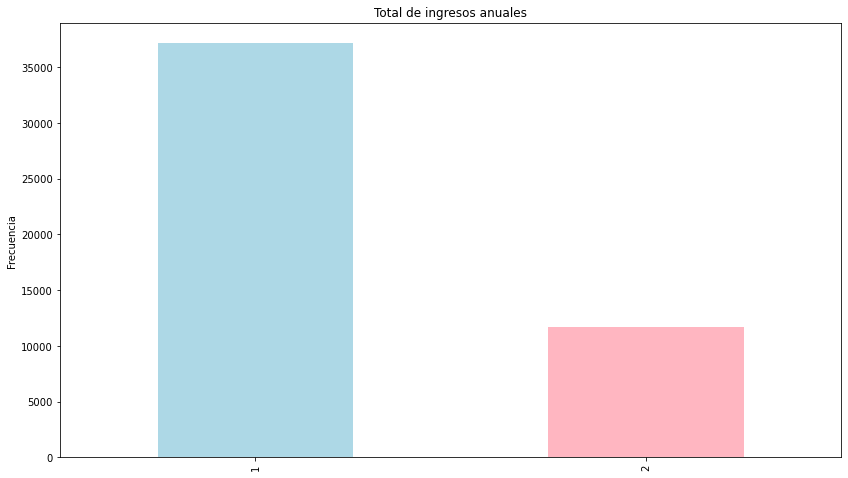

In [19]:
print(datos['income'].value_counts()/sum(datos['income'].value_counts())*100)
ax = datos['income'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Total de ingresos anuales", color=["lightblue","lightpink"])
ax.set_ylabel("Frecuencia")

Como podemos observar en la gráfica de arriba, existe una desproporción entre las familias que ganan más de 50k al año y aquellas que ganan menos. Para poder analizar los datos de una formas mas precisa, vamos a dividir los conjuntos de entrenamiento y validación de forma, porque de lo contrario, es posible que la gran parte de un tipo de hogar estén en un mismo subgrupo.

In [20]:
datos[datos.columns[1:]].corr()['income'][:].sort_values(ascending=False)

income             1.000000
educational-num    0.332613
hours-per-week     0.227687
capital-gain       0.223013
education          0.160178
workclass          0.153261
capital-loss       0.147554
occupation         0.075196
race               0.032272
native-country    -0.001382
marital-status    -0.003602
fnlwgt            -0.006339
relationship      -0.060166
gender            -0.214628
Name: income, dtype: float64

Podemos ver como ninguna de las variables esta correlacionada con la variable *income*, significando que son independientes entre ellas.

In [21]:
num = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week','workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']
datos = datos[num].astype(int)

In [22]:
#usamos esto para dividir el conjunto de train y el de test

income = ['income']

X = datos.drop(income,axis=1)
Y = datos[income]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=0)

print("El conjunto de entrenamiento tiene {} ejemplos.".format(x_train.shape[0]))
print("El conjunto de validación tiene {} ejemplos.".format(x_test.shape[0]))

El conjunto de entrenamiento tiene 34189 ejemplos.
El conjunto de validación tiene 14653 ejemplos.


In [23]:
# conjunto de validación
print(x_test.shape)

print(y_test['income'].value_counts()/sum(y_test['income'].value_counts())*100)
y_test.value_counts()

(14653, 14)
1    76.011738
2    23.988262
Name: income, dtype: float64


income
1         11138
2          3515
dtype: int64

In [24]:
# conjunto de entrenamiento
print(x_train.shape)

print(y_train['income'].value_counts()/sum(y_train['income'].value_counts())*100)
y_train.value_counts()

(34189, 14)
1    76.097575
2    23.902425
Name: income, dtype: float64


income
1         26017
2          8172
dtype: int64

Al dividirlo, podemos ver como se mantiene la proporcion en cada conjunto del total de ingresos de cada hogar, el 76% tiene menos de 50k ingresos anuales versus el 24% que tiene más, por lo que se mantiene la distribución inicial, pero los datos estan mas repartidos. 

# MODELO DESCRIPTIVO

A continuación probaremos distintos modelos con el objetivo de encontrar el más adecuado para solventar el problema, en concreto usaremos 4 modelos:

- Random Forest
- Gradient Boosting
- Árbol de decision simple
- XGBoost

### Random Forest

In [25]:
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (34189, 14)
Training Labels Shape: (34189, 1)
Testing Features Shape: (14653, 14)
Testing Labels Shape: (14653, 1)


Importamos el modelo de regresión de Random Forest de scikit-learn, metemos el modelo y ajustamos el modelo en los datos de entrenamiento.

In [26]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Entrenar el modelo
rfr.fit(x_train,y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

Ahora hacemos predicciones sobre las características de los datos de validación. Luego, comparamos las predicciones con las respuestas anteriores. 
Al realizar la regresión, utilizamos el error absoluto, porque algunas de nuestras respuestas serán bajas y otras altas.

In [27]:
# Método de predicción del bosque en los datos de test
pred = rfr.predict(x_test)

# Calcular los errores absolutos
pred = pred.reshape(14653,1)
err = abs(pred - y_test)

# Error absoluto medio
print('Error absoluto medio:', round(np.mean(err), 2), 'degrees.')

Error absoluto medio: income    0.19
dtype: float64 degrees.


Para poner las predicciones en perspectiva, calculamos la precisión utilizando el error porcentual medio menos el 100 %.

In [28]:
# Calcular el error porcentual absoluto medio
epam = 100 * (err / y_test)

# Calcular la métrica de precisión
acc = 100 - np.mean(epam)
print('Accuracy:', round(acc, 2), '%.')

Accuracy: income    85.69
dtype: float64 %.


Podemos ver como nuestra métrica de exactitud es de un 

### Arbol de decisión simple

Primero empezamos creando el modelo de árbol de decisión. Luego procedemos a generar las distintas métricas, y podemos ver como la de exactitud, que es de un 81.33%.

In [29]:
from sklearn import metrics 

# Crear objeto clasificador de árbol de decisión
dtc = DecisionTreeClassifier()

# Clasificador de árboles de decisión de train
dtc = dtc.fit(x_train,y_train)

# Predecir la respuesta para el conjunto de datos de prueba
y_pred = dtc.predict(x_test)

print("Métrica de exhaustividad:",metrics.recall_score(y_test, y_pred))
print("Métrica de precisión: ",metrics.precision_score(y_test, y_pred))
print("Métrica de exactitud:",metrics.accuracy_score(y_test, y_pred))
print("Score F1:",metrics.f1_score(y_test, y_pred))
print("Área bajo la curva:",metrics.roc_auc_score(y_test, y_pred))

Métrica de exhaustividad: 0.8700843957622554
Métrica de precisión:  0.8830872972480408
Métrica de exactitud: 0.8136900293455265
Score F1: 0.8765376266280752
Área bajo la curva: 0.752538641693361


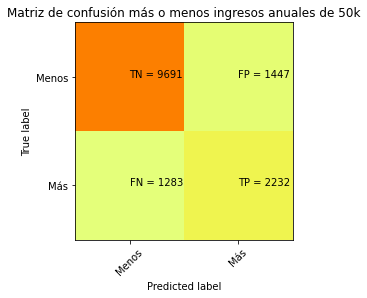

In [30]:
# Matriz de correlación
cm = metrics.confusion_matrix(y_test, y_pred)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
class1 = ['Menos','Más']
plt.title('Matriz de confusión más o menos ingresos anuales de 50k')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(class1))
plt.xticks(tick_marks, class1, rotation=45)
plt.yticks(tick_marks, class1)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

Cuando analizamos la matriz de confusión, podemos ver que con este modelo hay muchos hogares que no ha conseguido identificar. La mayoria que identifica con los True Negative, que son aquellas familias que el modelo predice que tienen menos de 50k ingresos anueales y que en realidad sí que tienen menos de 50k ingresos anuales. 

### Gradient Boosting

Creamos el modelo y realizamos su entrenamiento. 

In [31]:
modelo = GradientBoostingRegressor(
            n_estimators = 10,
            loss         = 'ls',
            max_features = 'auto',
            random_state = 123
         )

modelo.fit(x_train, y_train)

GradientBoostingRegressor(max_features='auto', n_estimators=10,
                          random_state=123)

Una vez entrenado el modelo, se evalúa la capacidad predictiva empleando el conjunto de test.

In [32]:
predicciones = modelo.predict(X = x_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.35441283592103895


Valor óptimo de n_estimators: 476


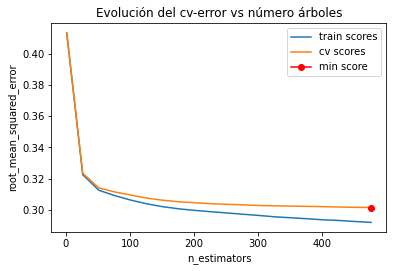

In [33]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error

train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 500, 25)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = GradientBoostingRegressor(
                n_estimators = n_estimators,
                loss         = 'ls',
                max_features = 'auto',
                random_state = 123
             )
    
    # Error de train
    modelo.fit(x_train, y_train)
    predicciones = modelo.predict(X = x_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = x_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1,
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

Los valores estimados por validación cruzada muestran que, a partir de los 20 árboles, el error del modelo se estabiliza, consiguiendo un mínimo con 500 árboles. 

### XGBoost

In [34]:
from xgboost import XGBClassifier

*CONJUNTO DE ENTRENAMIENTO (TRAIN)*

In [35]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

modelo = XGBClassifier(subsample = 0.7, max_depth = 4)
modelo.fit(x_train, y_train, eval_metric='rmse')

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [36]:
# Métrica de exactitud
accuracy_score(y_train, modelo.predict(x_train))

0.8866302026967738

Por ahora, esta es el mayor porcentage de exatitud que hemos conseguido en los modelos, por lo que optimizaremos XGBoost para poder dar una solución a CharityML.

In [37]:
# Métrica de precisión
precision_score(y_train, modelo.predict(x_train))

0.8125727590221188

In [38]:
# Métrica de exhaustividad
recall_score(y_train, modelo.predict(x_train))

0.6833088595203133

In [39]:
#Score F1
f1_score(y_train, modelo.predict(x_train))

0.7423557564477533

In [40]:
# Área bajo la curva
roc_auc_score(y_train, modelo.predict(x_train))
# 0.7129048578859443

0.8169013836749047

In [41]:
# Matriz de confusión
cm = confusion_matrix(y_train, modelo.predict(x_train))
cm

array([[24729,  1288],
       [ 2588,  5584]])

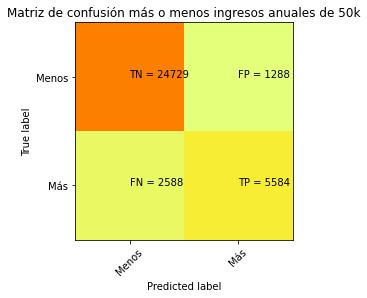

In [42]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
class1 = ['Menos','Más']
plt.title('Matriz de confusión más o menos ingresos anuales de 50k')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(class1))
plt.xticks(tick_marks, class1, rotation=45)
plt.yticks(tick_marks, class1)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

También podemos ver como en esta matriz de correlación aparecen muchos mas hogares, y se ha reducido el número de falsos positivos por casi 200.

*CONJUNTO DE VALIDACIÓN (TEST)*

In [43]:
# Métrica de exactitud
accuracy_score(y_test, modelo.predict(x_test))

0.04497372551695898

In [44]:
# Área bajo la curva
roc_auc_score(y_test, modelo.predict(x_test))

0.7968746288320814

In [45]:
# Matriz de confusión
cm = confusion_matrix(y_test, modelo.predict(x_test))
cm

array([[    0,     0,     0],
       [10479,   659,     0],
       [ 1220,  2295,     0]])

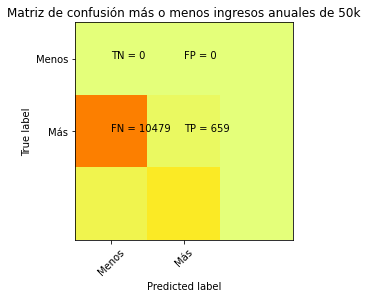

In [46]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
class1 = ['Menos','Más']
plt.title('Matriz de confusión más o menos ingresos anuales de 50k')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(class1))
plt.xticks(tick_marks, class1, rotation=45)
plt.yticks(tick_marks, class1)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

# MODELO PREDICTIVO

Tras ver los distintos modelos, he decidido analizar mas en profundidad XGBoost, ya que es el que tiene mayor métrica de exactitud comparandolo con el resto de modelos, y analizando las matrices de confusión es la que más precisión nos puede ofrecer. 

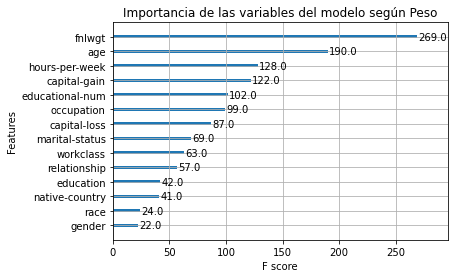

In [47]:
# Importancia por peso
xgb.plot_importance(modelo)
plt.title('Importancia de las variables del modelo según Peso')
plt.show()

Este se suele usar por defecto, ya que el peso indica el número de veces que se utilizó la función para segmentar los datos. La clase de importancia de característica prioriza atributos numéricos y numéricos altos.

- En este caso, la variable más importante es **fnlwgt** con 269, duplicando a la tercera variable por importancia. A este le sigue **age**, **hours per week**, **capital gain** y **educational num**. 

- La variable de peso menos significativa es **gender** con 22 puntos, a la cual le supera **race** por 2 puntos más, y a este **native country** con un total de 41 puntos.

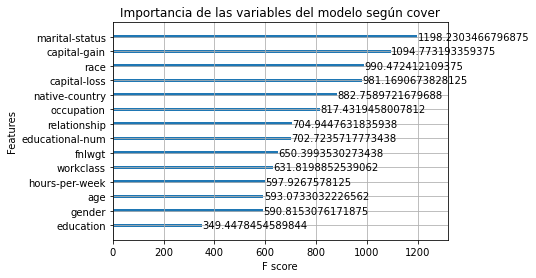

In [48]:
# Importancia por cover
xgb.plot_importance(modelo, importance_type="cover")
plt.title('Importancia de las variables del modelo según cover')
plt.show()

La importancia por cover significa el número relativo de observaciones relacionadas con esta característica.

- En este caso, la variable más importante es **martial status** con 1198. A este le sigue **capital gain**, **race**, **capital loss** y **native country**. 

- La variable de peso menos significativa es **education** con 349 puntos, a la cual le supera **gender** con 590 puntos, y a este **age** con solo 3 puntos de más. 

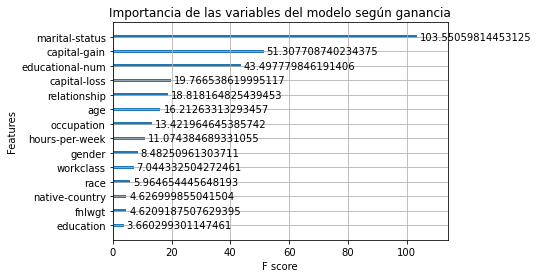

In [49]:
# Importancia por ganancia
xgb.plot_importance(modelo, importance_type="gain")
plt.title('Importancia de las variables del modelo según ganancia')
plt.show()

La ganancia está relacionada con la contribución relativa decada variable en cuestión al modelo, calculada tomando la contribución de cada característica para cada árbol modelo. Un valor más alto indica que la generación predictiva es más importante. Por lo tanto, la ganancia es la característica más apropiada para explicar la importancia relativa de cada característica.

- En este caso, la variable más importante es **martial status** con 103. A este le sigue **capital gain**, **educational num**, **capital loss** y **relationship**. 

- La variable de peso menos significativa es **education** con 3 puntos, a la cual le supera **gender** con 590 puntos, y a este **age** con solo 3 puntos de más. 

Ya que tenemos la varible mas importante es **marital status**, eliminamos aquellas hogares que ganan menos de 50k anuales, para que nos de una mayor precision sobre que tipo de situación matrimonial es mas probable de donar. 

In [50]:
datos = datos[datos["income"].isin([2])]

2    85.428254
1     6.271926
4     5.741422
3     1.095234
5     0.847095
6     0.496278
7     0.119791
Name: marital-status, dtype: float64


Text(0, 0.5, 'Frecuencia')

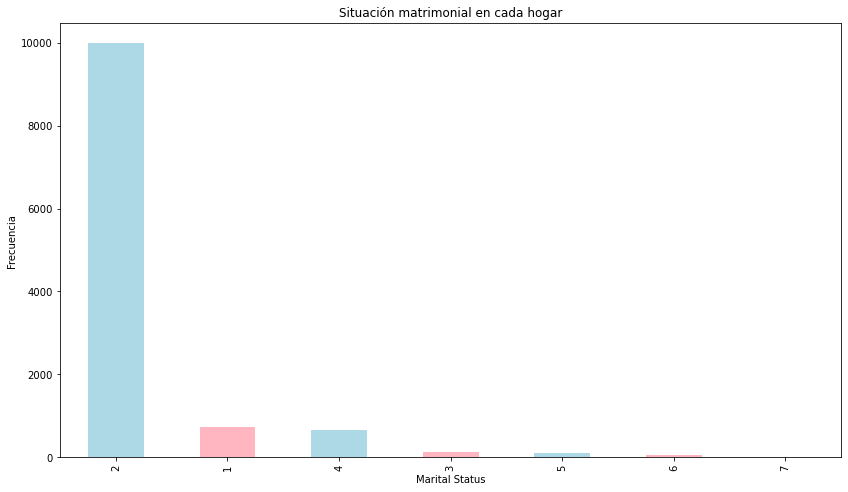

In [51]:
print(datos['marital-status'].value_counts()/sum(datos['marital-status'].value_counts())*100)
ax = datos['marital-status'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Situación matrimonial en cada hogar", color=["lightblue","lightpink"])
ax.set_xlabel("Marital Status")
ax.set_ylabel("Frecuencia")

El valor de cada variable: 
- 1: Never-married
- 2: Married-civ-spouse
- 3: Widowed
- 4: Divorced
- 5: Separated
- 6: Married-spouse-absent
- 7: Married-AF-spouse

## CONCLUSIONES

- El modelo XGBoost es el más adecuado para resolver el problema de decisión que tiene CharityML, para predecir las personas con más probabilidades de donar a su causa.
- Analizando el modelo modelo XGBoost, podemos ver que de las tres importancias (peso, cover y ganancia), en dos de ellas la variable que mas influencia tiene es **marital status** (situación matrimonial del hogar), por lo que se ha elegido esa para analizarla en mas profundidad.
- Podemos ver que los hogares con mas probabilidad de donar son principalmente married-civ-spouse (85.43%), seguido por los que nunca se han casado (6.27%), están divorciados (5.74%), los viudos (1.1%), los que estan separados (0.85%) y finalmente Married-AF-spouse (0.12%).